In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [300]:
! git clone https://github.com/ryuntp/floodDetection.git

fatal: destination path 'floodDetection' already exists and is not an empty directory.


In [0]:
path = Path('floodDetection')

In [0]:
path_labels = path/"labels"
path_images = path/'images'

In [304]:
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('floodDetection/images/Label_3.png'),
 PosixPath('floodDetection/images/Label_32.png'),
 PosixPath('floodDetection/images/Label_9.png'),
 PosixPath('floodDetection/images/Label_44.png'),
 PosixPath('floodDetection/images/Label_53.png'),
 PosixPath('floodDetection/images/Label_23.png'),
 PosixPath('floodDetection/images/Label_59.png'),
 PosixPath('floodDetection/images/Label_63.png'),
 PosixPath('floodDetection/images/Label_50.png'),
 PosixPath('floodDetection/images/Label_24.png')]

In [302]:
label_names = get_image_files(path_labels)
label_names[:10]

[PosixPath('floodDetection/labels/Label_5_P.png'),
 PosixPath('floodDetection/labels/Label_14_P.png'),
 PosixPath('floodDetection/labels/Label_39_P.png'),
 PosixPath('floodDetection/labels/Label_57_P.png'),
 PosixPath('floodDetection/labels/Label_33_P.png'),
 PosixPath('floodDetection/labels/Label_65_P.png'),
 PosixPath('floodDetection/labels/Label_61_P.png'),
 PosixPath('floodDetection/labels/Label_38_P.png'),
 PosixPath('floodDetection/labels/Label_29_P.png'),
 PosixPath('floodDetection/labels/Label_22_P.png')]

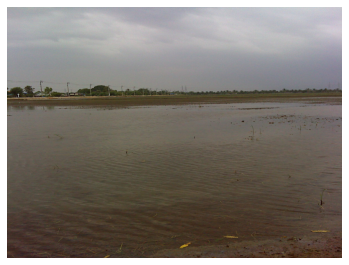

In [301]:
image_file = filenames[29]
image = open_image(image_file)
image.show(figsize=(6,6))

In [0]:
get_y_fn = lambda x: str(path_labels)+"/"+ f'{x.stem}_P{x.suffix}'

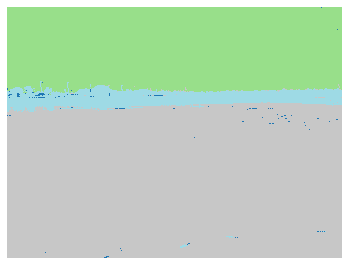

In [311]:
mask = open_mask(get_y_fn(image_file))
mask.show(figsize=(6,6), alpha=1)

In [307]:
source_size = np.array(mask.shape[1:])
source_size, mask.data

(array([720, 960]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [309]:
codes = np.loadtxt(path/'code.txt', dtype=str)
len(codes), codes

(4, array(['sky', 'rice', 'water', 'backg'], dtype='<U5'))

In [314]:
size = source_size//2
bs = 0

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 16000: bs=16    
elif free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 0MB of GPU RAM free


In [0]:
segmentitemlist = (SegmentationItemList.from_folder(path_images)
              .split_by_rand_pct(valid_pct=0.2)
              .label_from_func(get_y_fn, classes=codes))
# print(segmentitemlist)

In [0]:
databunch = (segmentitemlist.transform(get_transforms(), 
                                  size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize(imagenet_stats))

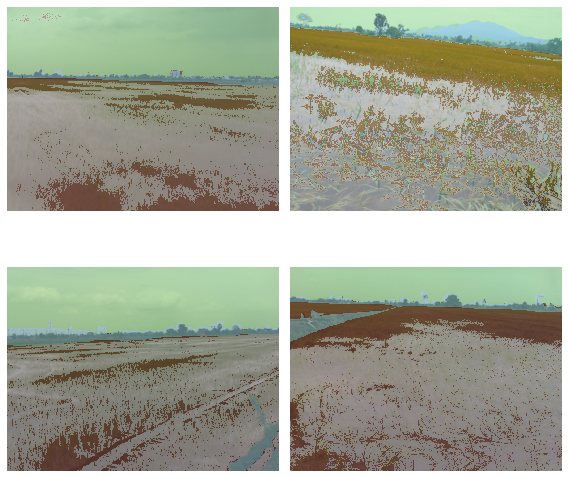

In [306]:
databunch.show_batch()

In [0]:
metrics=accuracy

In [0]:
wd=1e-2

In [0]:
learner = unet_learner(databunch, models.resnet34, 
                       metrics=metrics, wd=wd, 
                       callback_fns=ShowGraph).to_fp32()

In [0]:
lr=3e-3

In [316]:
learner.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy,time


IndexError: ignored